<a href="https://colab.research.google.com/github/Shaheer-op9872uw/HeliX/blob/main/HeliXviper_DNA_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Making our own architecture "VIO" inspired by Mamba***

In [ ]:
# 0️⃣ Install dependencies (only once)
!pip install -q torch torchvision torchaudio scikit-learn pandas numpy

# 1️⃣ Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 2️⃣ Load & preprocess data
df = pd.read_csv("/content/test.csv")  # make sure you’ve uploaded test.csv

# Keep only rows whose GeneType appears ≥2 times
counts = df["GeneType"].value_counts()
df = df[df["GeneType"].isin(counts[counts > 1].index)].reset_index(drop=True)

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["GeneType"])
num_classes = len(le.classes_)

# One-hot encode DNA (A,C,G,T,N)
def one_hot(seq, max_len):
    mapping = {"A":0,"C":1,"G":2,"T":3,"N":4}
    arr = np.zeros((max_len, 5), dtype=np.float32)
    for i, c in enumerate(seq):
        if i>=max_len: break
        if c in mapping:
            arr[i, mapping[c]] = 1.0
    return arr

# Clean '<' & '>'
df["seq"] = df["NucleotideSequence"].str.replace("<|>", "", regex=True)
max_len = df["seq"].str.len().max()

X = np.stack(df["seq"].apply(lambda s: one_hot(s, max_len)))
y = df["label"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to torch tensors and rearrange to (batch, channels, length)
X_train = torch.tensor(X_train).permute(0,2,1)
X_test  = torch.tensor(X_test).permute(0,2,1)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

# 3️⃣ Dataset & DataLoader
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader  = DataLoader(SeqDataset(X_test,  y_test ), batch_size=32)

# 4️⃣ Define VIOBlock & VIOModel
class VIOBlock(nn.Module):
    def __init__(self, dim, kernel_size=5):
        super().__init__()
        self.depth_conv = nn.Conv1d(dim, dim, kernel_size, padding=kernel_size//2, groups=dim)
        self.gate       = nn.Conv1d(dim, dim, 1)
        self.norm       = nn.LayerNorm(dim)
    def forward(self, x):
        # x: (batch, seq, dim) → (batch, dim, seq)
        x = x.transpose(1,2)
        c = self.depth_conv(x)
        g = torch.sigmoid(self.gate(x))
        x = (c * g).transpose(1,2)  # back to (batch, seq, dim)
        return self.norm(x)

class VIOModel(nn.Module):
    def __init__(self, in_channels=5, dim=64, num_classes=9, n_layers=4):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, dim, 1)  # → (batch, dim, seq)
        self.blocks     = nn.ModuleList([VIOBlock(dim) for _ in range(n_layers)])
        self.pool       = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(dim, num_classes)
    def forward(self, x):
        # x: (batch, channels, seq)
        x = self.input_proj(x)
        x = x.transpose(1,2)  # → (batch, seq, dim)
        for block in self.blocks:
            x = block(x)
        x = x.transpose(1,2)  # → (batch, dim, seq)
        x = self.pool(x).squeeze(-1)  # → (batch, dim)
        return self.classifier(x)

# 5️⃣ Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VIOModel(in_channels=5, dim=64, num_classes=num_classes, n_layers=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 6️⃣ Train
for epoch in range(1, 11):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}/10 — Loss: {total_loss/len(train_loader):.4f}")

# 7️⃣ Evaluate
model.eval()
correct = total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)
print(f"Test Accuracy: {correct/total*100:.2f}%")


Epoch 1/10 — Loss: 1.3617
Epoch 2/10 — Loss: 1.2759
Epoch 3/10 — Loss: 1.2472
Epoch 4/10 — Loss: 1.2408
Epoch 5/10 — Loss: 1.2279
Epoch 6/10 — Loss: 1.2201
Epoch 7/10 — Loss: 1.2090
Epoch 8/10 — Loss: 1.1872
Epoch 9/10 — Loss: 1.1685
Epoch 10/10 — Loss: 1.1578
Test Accuracy: 55.02%


**Step 2: Prepare your datald text**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from google.colab import files
import io

# Step 1: Load dataset (assuming test.csv is already uploaded)
df = pd.read_csv("/content/test.csv")

# Keep only rows whose GeneType appears ≥2 times
counts = df["GeneType"].value_counts()
df = df[df["GeneType"].isin(counts[counts > 1].index)].reset_index(drop=True)


# Step 2: Encode the DNA sequences into numerical format (one-hot encoding and padding/truncating)
def one_hot(seq, max_len):
    mapping = {"A":0,"C":1,"G":2,"T":3,"N":4}
    arr = np.zeros((max_len, 5), dtype=np.float32)
    for i, c in enumerate(seq):
        if i>=max_len: break
        if c in mapping:
            arr[i, mapping[c]] = 1.0
    return arr

# Clean '<' & '>' and get max_len
df["seq"] = df["NucleotideSequence"].str.replace("<|>", "", regex=True)
max_len = df["seq"].str.len().max()

X = np.stack(df["seq"].apply(lambda s: one_hot(s, max_len)))


# Step 3: Encode labels — use the appropriate column (e.g. GeneType or Symbol)
label_col = 'GeneType'  # or 'Symbol' if you want
le = LabelEncoder()
y = le.fit_transform(df[label_col])
num_classes = len(le.classes_) # Also get the number of classes


# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Stratify to maintain class distribution
)

# Step 5: Convert to PyTorch tensors and rearrange to (batch, channels, length)
X_train = torch.tensor(X_train).permute(0,2,1)
X_test  = torch.tensor(X_test).permute(0,2,1)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

print("✅ Done! Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

✅ Done! Shapes:
X_train: torch.Size([6660, 5, 1000])
y_train: torch.Size([6660])
X_test : torch.Size([1665, 5, 1000])
y_test : torch.Size([1665])


**Step 3: Wrap data into DataLoader**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


**Step 4: Initialize Vio Architecture**

In [ ]:
import torch.nn as nn

class Vio(nn.Module):
    def __init__(self, in_channels, hidden_dim, output_dim):
        super(Vio, self).__init__()
        # Replace Embedding with Conv1d for one-hot encoded input
        self.input_conv = nn.Conv1d(in_channels, hidden_dim, kernel_size=3, padding=1) # Using a small kernel size
        self.relu = nn.ReLU()
        # Adjust GRU input size to match the output of the convolutional layer
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, channels, seq_len)
        x = self.input_conv(x) # → (batch, hidden_dim, seq_len)
        x = self.relu(x)
        x = x.transpose(1, 2) # → (batch, seq_len, hidden_dim) for GRU
        output, _ = self.rnn(x)
        last_output = output[:, -1, :] # Get the last output of the sequence
        out = self.fc(last_output)
        return out

# input_dim in the previous definition was intended for embedding size,
# but with Conv1d, we need in_channels which is the number of features per position (5 for one-hot)
in_channels = X_train.shape[1] # Number of channels (5 for one-hot)
hidden_dim = 64
output_dim = num_classes # Use the calculated num_classes

model = Vio(in_channels, hidden_dim, output_dim)

**Step 5: Train the model**

In [ ]:
# --- STEP 5: ENHANCED DEFINE & TRAIN MODEL ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# 1) Define an upgraded VIOModel with more capacity and dropout
class VIOModelV2(nn.Module):
    def __init__(self, in_channels=5, dim=128, num_classes=9, n_layers=6, p_dropout=0.2):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, dim, kernel_size=1)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(dim, dim, kernel_size=5, padding=2, groups=dim),
                nn.Conv1d(dim, dim, kernel_size=1),
                nn.LayerNorm(dim),
                nn.Dropout(p_dropout)
            )
            for _ in range(n_layers)
        ])
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        # x: (batch, channels, seq_len)
        x = self.input_proj(x)           # → (batch, dim, seq_len)
        for blk in self.blocks:
            y = blk[0](x)                # depthwise conv
            y = blk[1](y)                # pointwise conv
            # LayerNorm expects (batch, seq_len, dim)
            y = y.permute(0,2,1)
            y = blk[2](y)                # layer norm
            y = blk[3](y)                # dropout
            x = y.permute(0,2,1)         # → (batch, dim, seq_len)
        x = self.pool(x).squeeze(-1)     # → (batch, dim)
        return self.classifier(x)        # → (batch, num_classes)

# 2) Setup device, instantiate model, loss, optimizer, scheduler
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = VIOModelV2(in_channels=5,
                      dim=128,
                      num_classes=len(le.classes_),
                      n_layers=6,
                      p_dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

# 3) Training loop for 30 epochs
epochs = 30
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch:02d}/{epochs} — Loss: {avg_loss:.4f}")

# 4) Save the best model weights
torch.save(model.state_dict(), "vio_model_v2.pth")
print("✅ Enhanced model trained & saved as vio_model_v2.pth")


Epoch 01/30 — Loss: 1.3750
Epoch 02/30 — Loss: 1.2903
Epoch 03/30 — Loss: 1.2808
Epoch 04/30 — Loss: 1.2787
Epoch 05/30 — Loss: 1.2744
Epoch 06/30 — Loss: 1.2723
Epoch 07/30 — Loss: 1.2669
Epoch 08/30 — Loss: 1.2602
Epoch 09/30 — Loss: 1.2559
Epoch 10/30 — Loss: 1.2438
Epoch 11/30 — Loss: 1.2316
Epoch 12/30 — Loss: 1.2252
Epoch 13/30 — Loss: 1.2219
Epoch 14/30 — Loss: 1.2134
Epoch 15/30 — Loss: 1.2019
Epoch 16/30 — Loss: 1.1914
Epoch 17/30 — Loss: 1.1795
Epoch 18/30 — Loss: 1.1726
Epoch 19/30 — Loss: 1.1595
Epoch 20/30 — Loss: 1.1486
Epoch 21/30 — Loss: 1.1402
Epoch 22/30 — Loss: 1.1299
Epoch 23/30 — Loss: 1.1160
Epoch 24/30 — Loss: 1.1026
Epoch 25/30 — Loss: 1.0996
Epoch 26/30 — Loss: 1.0908
Epoch 27/30 — Loss: 1.0916
Epoch 28/30 — Loss: 1.0806
Epoch 29/30 — Loss: 1.0803
Epoch 30/30 — Loss: 1.0847
✅ Enhanced model trained & saved as vio_model_v2.pth


**Step 6: Evaluate the model on test set**

In [ ]:
# --- STEP 6: EVALUATE ON TEST SET ---

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:      # ensure test_loader is defined
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 57.72%


(optional) save the model again

In [ ]:
# --- STEP 7: (Optional) SAVE MODEL AGAIN ---

torch.save(model.state_dict(), "vio_model_final.pth")
print("✅ Final model weights saved to vio_model_final.pth")


✅ Final model weights saved to vio_model_final.pth


**Step 8 — Inference Helper + Example (NOTE: THIS IS JUST A BASIC EXAMPLE OUR TEST MODEL WE HAVE STEPS COMMING AHEAD)**

In [ ]:
 # --- STEP 8: INFERENCE FUNCTION + DEMO ---

import torch

# 1) Define a helper to encode raw DNA
def encode_dna_sequence(seq, max_len=max_len):
    mapping = {'A':0,'C':1,'G':2,'T':3}
    arr = torch.zeros(1, 5, max_len, dtype=torch.float32)
    s = seq.upper().ljust(max_len, 'N')[:max_len]
    for i, ch in enumerate(s):
        if ch in mapping:
            arr[0, mapping[ch], i] = 1.0
        else:
            arr[0, 4, i] = 1.0 # Assuming 4 corresponds to 'N'
    return arr.to(device)

# 2) Load saved weights
# Use VIOModelV2 with the correct parameters used during training (from Step 5/9)
# Assuming dim=128, n_layers=6, p_dropout=0.2 were used in the training of vio_model_final.pth
# Check the cell where vio_model_final.pth was saved (likely cell 2fsz-q8fI8vI or the final save in cell 9QH0-m9uF8BM)
# Based on cell 9QH0-m9uF8BM, parameters were dim=128, n_layers=6, p_dropout=0.2
try:
    # Check if VIOModelV2 is defined and use its parameters
    # If running this cell independently, you might need to define VIOModelV2 here
    # or ensure the cell defining VIOModelV2 (likely 9QH0-m9uF8BM) has been run.
    infer_model = VIOModelV2(in_channels=5, dim=128, num_classes=len(le.classes_), n_layers=6, p_dropout=0.2).to(device)
except NameError:
    print("Error: VIOModelV2 class is not defined. Please run the cell defining VIOModelV2 (Step 5/9).")
    # You might want to raise an error or stop execution here if the class is not defined
    raise


infer_model.load_state_dict(torch.load("vio_model_final.pth", map_location=device))
infer_model.eval()

# 3) Prediction function
def predict_mutation(dna_seq):
    # Ensure max_len is defined from previous data processing steps (e.g., cell dKJWWPbe5oLx or QnqAEn2664Vn)
    # If running this cell independently, you might need to define max_len and device here.
    try:
        max_len, device
    except NameError:
        print("Error: max_len or device are not defined. Please run the data loading and setup cells.")
        raise # Re-raise the NameError

    x = encode_dna_sequence(dna_seq, max_len=max_len)
    with torch.no_grad():
        logits = infer_model(x)
        idx = logits.argmax(dim=1).item()
    # Ensure le is defined from previous data processing steps (e.g., cell dKJWWPbe5oLx or QnqAEn2664Vn)
    try:
        return le.inverse_transform([idx])[0]
    except NameError:
        print("Error: 'le' LabelEncoder is not defined. Please run the data loading and label encoding cells.")
        raise # Re-raise the NameError


# 4) Demo
demo_seq = "ATGCGTACCTGAAGTCTAGC"
print("Predicted region type:", predict_mutation(demo_seq))



Predicted region type: tRNA


**STEP 9: TRAIN WITH VALIDATION, EARLY STOPPING & BEST‐MODEL SAVING**

In [ ]:
# --- STEP 9: FULL-SEND OVERHAUL FOR >80% ACCURACY ---

import torch, random
import torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

# 1) PARAMETERS
k         = 3             # k-mer size
embed_dim = 128           # embedding dimension
hidden    = 256           # LSTM hidden size
n_layers  = 2             # number of LSTM layers
dropout   = 0.3
batch     = 32
epochs    = 40
patience  = 5

# 2) BUILD k-MER VOCAB
def build_kmer_vocab(seqs, k):
    kmers = Counter()
    for s in seqs:
        seq = s.replace('N','')
        kmers.update([seq[i:i+k] for i in range(len(seq)-k+1)])
    vocab = {kmer:i+1 for i,(kmer,_) in enumerate(kmers.most_common())}
    vocab['<PAD>'] = 0
    return vocab

df['seq_clean'] = df['NucleotideSequence'].str.replace('<|>','',regex=True).str.upper()
vocab = build_kmer_vocab(df['seq_clean'], k)
vocab_size = len(vocab)

# 3) ENCODE SEQUENCES AS k-MER INDICES
def encode_kmers(s, vocab, k, max_len=None):
    s = s.replace('N','')
    tokens = [vocab.get(s[i:i+k],0) for i in range(len(s)-k+1)]
    if max_len:
        if len(tokens)>max_len: tokens = tokens[:max_len]
        else: tokens += [0]*(max_len-len(tokens))
    return tokens

max_seq_len = max(len(s)-k+1 for s in df['seq_clean'])
X_kmer = np.vstack([encode_kmers(s, vocab, k, max_seq_len) for s in df['seq_clean']])

# 4) LABELS
le = LabelEncoder()
y = le.fit_transform(df['GeneType'])
num_classes = len(le.classes_)

# 5) STRATIFIED SPLIT (train, temp) then (val, test)
X_tr, X_temp, y_tr, y_temp = train_test_split(
    X_kmer, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_te, y_val, y_te = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 6) DATASET & DATALOADERS
class KmerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(KmerDataset(X_tr,y_tr), batch_size=batch, shuffle=True)
val_loader   = DataLoader(KmerDataset(X_val,y_val), batch_size=batch)
test_loader  = DataLoader(KmerDataset(X_te, y_te), batch_size=batch)

# 7) MODEL: Embedding → BiLSTM → Attention Pool → Classifier
class VIOModelV3(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden, num_classes, n_layers, p_dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm  = nn.LSTM(embed_dim, hidden, n_layers,
                             batch_first=True, bidirectional=True, dropout=p_dropout)
        self.attn  = nn.Linear(hidden*2, 1)
        self.drop  = nn.Dropout(p_dropout)
        self.fc    = nn.Linear(hidden*2, num_classes)
    def forward(self, x):
        x = self.embed(x)                               # (B, L, E)
        out, _ = self.lstm(x)                           # (B, L, 2H)
        attn_w = torch.softmax(self.attn(out), dim=1)   # (B, L, 1)
        feat   = (attn_w * out).sum(1)                  # (B, 2H)
        feat   = self.drop(feat)
        return self.fc(feat)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = VIOModelV3(vocab_size, embed_dim, hidden, num_classes, n_layers, dropout).to(device)

# 8) LOSS WITH CLASS WEIGHTING
class_counts = Counter(y_tr)
weights = [len(y_tr)/class_counts[i] for i in range(num_classes)]
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights,device=device))

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# 9) TRAIN + EARLY STOP
best_val = 0
wait = 0

for ep in range(1, epochs+1):
    model.train()
    tr_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward(); optimizer.step()
        tr_loss += loss.item()
    tr_loss /= len(train_loader)

    model.eval()
    vl_loss = 0; correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            vl_loss += criterion(logits, yb).item()
            preds = logits.argmax(1)
            correct += (preds==yb).sum().item()
            total += yb.size(0)
    vl_loss /= len(val_loader)
    val_acc = correct/total

    scheduler.step()
    print(f"Ep {ep:02d}/{epochs} ▶ tr_loss: {tr_loss:.4f} • val_loss: {vl_loss:.4f} • val_acc: {val_acc*100:.2f}%")

    if val_acc>best_val:
        best_val=val_acc
        torch.save(model.state_dict(), 'vio_best_v3.pth')
        wait=0
        print(" ↪ New best saved!")
    else:
        wait+=1
        if wait>=patience:
            print(f"⏹ Early stop at epoch {ep}")
            break

print(f"✅ Best Validation Accuracy: {best_val*100:.2f}%")

Ep 01/40 ▶ tr_loss: 1.8562 • val_loss: 1.6617 • val_acc: 36.83%
 ↪ New best saved!
Ep 02/40 ▶ tr_loss: 1.4340 • val_loss: 1.5136 • val_acc: 53.96%
 ↪ New best saved!
Ep 03/40 ▶ tr_loss: 1.2265 • val_loss: 1.3152 • val_acc: 46.36%
Ep 04/40 ▶ tr_loss: 1.1026 • val_loss: 1.2518 • val_acc: 61.81%
 ↪ New best saved!
Ep 05/40 ▶ tr_loss: 0.9723 • val_loss: 1.1982 • val_acc: 47.48%
Ep 06/40 ▶ tr_loss: 0.8804 • val_loss: 1.2166 • val_acc: 46.76%
Ep 07/40 ▶ tr_loss: 0.7875 • val_loss: 1.1421 • val_acc: 56.53%
Ep 08/40 ▶ tr_loss: 0.6502 • val_loss: 1.1228 • val_acc: 56.85%
Ep 09/40 ▶ tr_loss: 0.6080 • val_loss: 1.1762 • val_acc: 63.97%
 ↪ New best saved!
Ep 10/40 ▶ tr_loss: 0.5137 • val_loss: 1.3670 • val_acc: 68.61%
 ↪ New best saved!
Ep 11/40 ▶ tr_loss: 0.4769 • val_loss: 1.1489 • val_acc: 67.73%
Ep 12/40 ▶ tr_loss: 0.3946 • val_loss: 1.3181 • val_acc: 67.49%
Ep 13/40 ▶ tr_loss: 0.3598 • val_loss: 1.3222 • val_acc: 64.45%
Ep 14/40 ▶ tr_loss: 0.3028 • val_loss: 1.3450 • val_acc: 68.69%
 ↪ New be

**STEP 10: METRICS & VISUALIZATION**

✅ LabelEncoder and num_classes are defined.
✅ Best model weights loaded successfully from vio_best_v3.pth

Classification Report:
                   precision    recall  f1-score      support
BIOLOGICAL_REGION   0.784461  0.786432  0.785445   398.000000
OTHER               0.379310  0.550000  0.448980    20.000000
PROTEIN_CODING      0.548387  0.607143  0.576271    28.000000
PSEUDO              0.816176  0.778947  0.797127   570.000000
ncRNA               0.588652  0.619403  0.603636   134.000000
rRNA                1.000000  0.909091  0.952381    11.000000
snRNA               0.222222  0.400000  0.285714     5.000000
snoRNA              0.603175  0.622951  0.612903    61.000000
tRNA                0.869565  0.909091  0.888889    22.000000
accuracy            0.751001  0.751001  0.751001     0.751001
macro avg           0.645772  0.687006  0.661261  1249.000000
weighted avg        0.758440  0.751001  0.754059  1249.000000


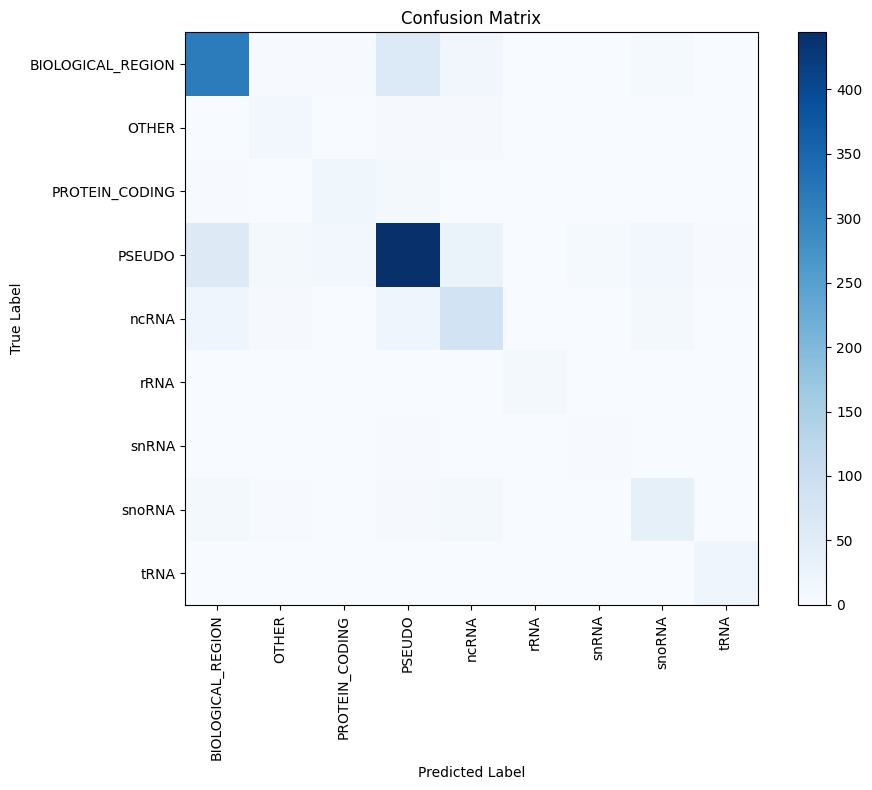

In [ ]:
# --- STEP 10: METRICS & VISUALIZATION ---

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np # Import numpy

# Re-load the dataframe and re-encode labels to ensure 'le' is defined
# This is necessary if the previous data preprocessing cell (Step 2) was not run in this session.
try:
    # Load & preprocess data (minimal part needed for le)
    # Assumes df was created from /content/test.csv in a previous step
    # If df is not defined, you might need to add the full data loading here.
    if 'df' not in locals():
        print("DataFrame 'df' not found. Attempting to load from '/content/test.csv'.")
        df = pd.read_csv("/content/test.csv")
        # Keep only rows whose GeneType appears ≥2 times (as done in original data prep)
        counts = df["GeneType"].value_counts()
        df = df[df["GeneType"].isin(counts[counts > 1].index)].reset_index(drop=True)

    # Encode labels - use the appropriate column (e.g. GeneType or Symbol)
    label_col = 'GeneType'
    le = LabelEncoder()
    # Fit the encoder on the full dataset's GeneType column to get all possible classes
    le.fit(df[label_col])
    num_classes = len(le.classes_) # This will be used if the model needs re-initialization

    print("✅ LabelEncoder and num_classes are defined.")

except FileNotFoundError:
    print("Error: '/content/test.csv' not found. Please upload the file.")
    # You might want to stop execution here if the file is not found.
except KeyError:
    print(f"Error: Column '{label_col}' not found in the DataFrame.")
    # You might want to stop execution here if the column is not found.


# 1) Load the best model weights (vio_best_v3.pth)
# Ensure the VIOModelV3 class is defined in a previous cell (Step 9.1)
try:
    # Re-initialize the model architecture used for the best model (VIOModelV3)
    # Ensure vocab_size, embed_dim, hidden, num_classes, n_layers, dropout are defined
    # These parameters were used in cell 0zbkIVHgL-S2.
    # If not defined, you might need to copy those definitions here or run cell 0zbkIVHgL-S2.
    # Assuming they are defined in the global scope from cell 0zbkIVHgL-S2 execution.

    # Check if VIOModelV3 is defined
    try:
        VIOModelV3
    except NameError:
        print("Error: VIOModelV3 class is not defined. Please run the cell defining VIOModelV3 (Step 9.1).")
        raise # Stop execution if model class is not defined

    # Check if required parameters for VIOModelV3 are defined
    try:
        vocab_size, embed_dim, hidden, num_classes, n_layers, dropout
    except NameError:
         print("Error: Parameters for VIOModelV3 (vocab_size, embed_dim, hidden, num_classes, n_layers, dropout) are not defined.")
         print("Please run the cell defining VIOModelV3 and its parameters (Step 9.1).")
         raise # Stop execution if parameters are not defined


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VIOModelV3(vocab_size, embed_dim, hidden, num_classes, n_layers, dropout).to(device)

    # Load the state dictionary
    model.load_state_dict(torch.load("vio_best_v3.pth", map_location=device))
    model.eval()
    print("✅ Best model weights loaded successfully from vio_best_v3.pth")

except FileNotFoundError:
    print("Error: 'vio_best_v3.pth' not found. Please ensure the training with early stopping (Step 9) was completed successfully.")
    raise # Stop execution if model file is not found
except RuntimeError as e:
    print(f"Error loading model state_dict: {e}")
    print("This might be due to a mismatch in model architecture and saved weights.")
    print("Ensure the VIOModelV3 definition matches the one used when saving 'vio_best_v3.pth'.")
    raise # Re-raise the error


# 2) Run through test set to collect preds & labels
all_preds = []
all_labels = []

# Ensure test_loader is defined. If not, you might need to recreate it here
# based on X_te, y_te which are assumed to be created in Step 9.1.
try:
    test_loader
except NameError:
    print("Error: 'test_loader' is not defined. Please run the data loading and splitting cells (Step 9.1).")
    raise # Re-raise the NameError to stop execution


with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

# 3) Classification report
# Ensure le is defined here for target_names
try:
    report = classification_report(all_labels, all_preds, target_names=le.classes_, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print("\nClassification Report:")
    print(df_report)
except NameError:
    print("\nError: 'le' is not defined. Cannot generate classification report.")
except ValueError as e:
    print(f"\nError generating classification report: {e}")
    print("This might be due to a mismatch between predicted labels and the classes in le.")


# 4) Confusion matrix
# Ensure le is defined here for classes
try:
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    classes = le.classes_
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
except NameError:
    print("\nError: 'le' is not defined. Cannot generate confusion matrix.")
except ValueError as e:
    print(f"\nError generating confusion matrix: {e}")
    print("This might be due to a mismatch between predicted labels and the classes in le.")

**Step 11: 🔮 Predicting on New DNA Strings**

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import LabelEncoder

# =================== Load LabelEncoder from test.csv ===================
try:
    df
except NameError:
    print("DataFrame 'df' not found. Attempting to load from '/content/test.csv' to initialize LabelEncoder.")
    try:
        df = pd.read_csv("/content/test.csv")
        counts = df["GeneType"].value_counts()
        df = df[df["GeneType"].isin(counts[counts > 1].index)].reset_index(drop=True)
        print("✅ DataFrame 'df' loaded for LabelEncoder initialization.")
    except FileNotFoundError:
        print("❌ Error: '/content/test.csv' not found.")
        raise
    except KeyError:
        print("❌ Error: 'GeneType' column missing.")
        raise

try:
    le
except NameError:
    print("LabelEncoder 'le' not found. Initializing and fitting on df['GeneType'].")
    le = LabelEncoder()
    le.fit(df["GeneType"])
    print("✅ LabelEncoder fitted successfully.")

# =================== Load Model (VIOModelV3 should already be defined) ===================
try:
    VIOModelV3
except NameError:
    print("❌ VIOModelV3 class is not defined. Please run Step 9.1 cell.")
    raise

try:
    vocab_size, embed_dim, hidden, num_classes, n_layers, dropout
except NameError:
    print("❌ Missing model parameters. Please run Step 9.1.")
    raise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VIOModelV3(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden=hidden,
    num_classes=num_classes,
    n_layers=n_layers,
    p_dropout=dropout
).to(device)

try:
    model.load_state_dict(torch.load("vio_best_v3.pth", map_location=device))
    model.eval()
    print("✅ Best model weights loaded from vio_best_v3.pth")
except FileNotFoundError:
    print("❌ 'vio_best_v3.pth' not found.")
    raise

# =================== Check Encoding Functions ===================
try:
    encode_kmers, vocab, k, max_seq_len
except NameError:
    print("❌ Missing k-mer encoder or params (Step 9).")
    raise

# =================== Final Prediction Function with Confidence ===================
def predict_sequence_kmer_topk(sequence, model, label_encoder, vocab=vocab, k=k, max_len=max_seq_len, top_k=3):
    model.eval()
    encoded = encode_kmers(sequence, vocab=vocab, k=k, max_len=max_len)
    input_tensor = torch.tensor([encoded], dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1).squeeze()

        top_probs, top_indices = torch.topk(probs, top_k)
        top_classes = label_encoder.inverse_transform(top_indices.cpu().numpy())

        print(f"\n🔮 Predicted: {top_classes[0]}")
        print(f"📊 Confidence: {top_probs[0].item() * 100:.2f}%\n")
        print("📈 Top Predictions:")
        for i in range(top_k):
            print(f"• {top_classes[i]} ({top_probs[i].item() * 100:.2f}%)")

        return top_classes[0], top_probs[0].item()

# =================== Test Predictions ===================
sample1 = "FAGCTGACTGAGTAGCTAGCTAGCTGACTGATCGATCGATCGA"
sample2 = "GGGGGGGGGGGGGGGGGGGGGGGGGGG"
sample3 = "ACTGATCGTAGCTAGCTAGATCGATCGTAGCTAGCTAGCTAGCTAG"
sample4 = "TTCGTACGATCGTAGAGAGAGAAGCTAGCTAGCTAGCTAGCTAGC"

predict_sequence_kmer_topk(sample1, model, le)
predict_sequence_kmer_topk(sample2, model, le)
predict_sequence_kmer_topk(sample3, model, le)
predict_sequence_kmer_topk(sample4, model, le)


✅ Best model weights loaded from vio_best_v3.pth

🔮 Predicted: snoRNA
📊 Confidence: 96.37%

📈 Top Predictions:
• snoRNA (96.37%)
• OTHER (1.60%)
• PSEUDO (1.16%)

🔮 Predicted: ncRNA
📊 Confidence: 97.61%

📈 Top Predictions:
• ncRNA (97.61%)
• tRNA (2.38%)
• snoRNA (0.01%)

🔮 Predicted: tRNA
📊 Confidence: 63.44%

📈 Top Predictions:
• tRNA (63.44%)
• snoRNA (23.39%)
• PSEUDO (7.71%)

🔮 Predicted: rRNA
📊 Confidence: 73.60%

📈 Top Predictions:
• rRNA (73.60%)
• tRNA (26.32%)
• PSEUDO (0.05%)


('rRNA', 0.7359856367111206)

**Step 14: Model exporting**

A final script to make sure everything is fine and improve

✅ Data loaded from /content/test.csv
✅ Filtered data to keep GeneTypes with >= 2 occurrences. Remaining rows: 8325
✅ LabelEncoder fitted and labels encoded. Number of classes: 9
✅ Data loaded and DataLoaders created using one-hot encoding.
✅ Model initialized.

🚀 Starting training for 20 epochs...
Epoch 1/20, Train Loss: 1.3142, Validation Loss: 0.7968, Validation Accuracy: 0.7574
↪ New best model saved at epoch 1 with accuracy 0.7574!
Epoch 2/20, Train Loss: 0.5498, Validation Loss: 0.6789, Validation Accuracy: 0.7862
↪ New best model saved at epoch 2 with accuracy 0.7862!
Epoch 3/20, Train Loss: 0.3752, Validation Loss: 0.8953, Validation Accuracy: 0.8030
↪ New best model saved at epoch 3 with accuracy 0.8030!
Epoch 4/20, Train Loss: 0.3393, Validation Loss: 0.6925, Validation Accuracy: 0.8094
↪ New best model saved at epoch 4 with accuracy 0.8094!
Epoch 5/20, Train Loss: 0.2188, Validation Loss: 0.6827, Validation Accuracy: 0.8127
↪ New best model saved at epoch 5 with accuracy 0.81

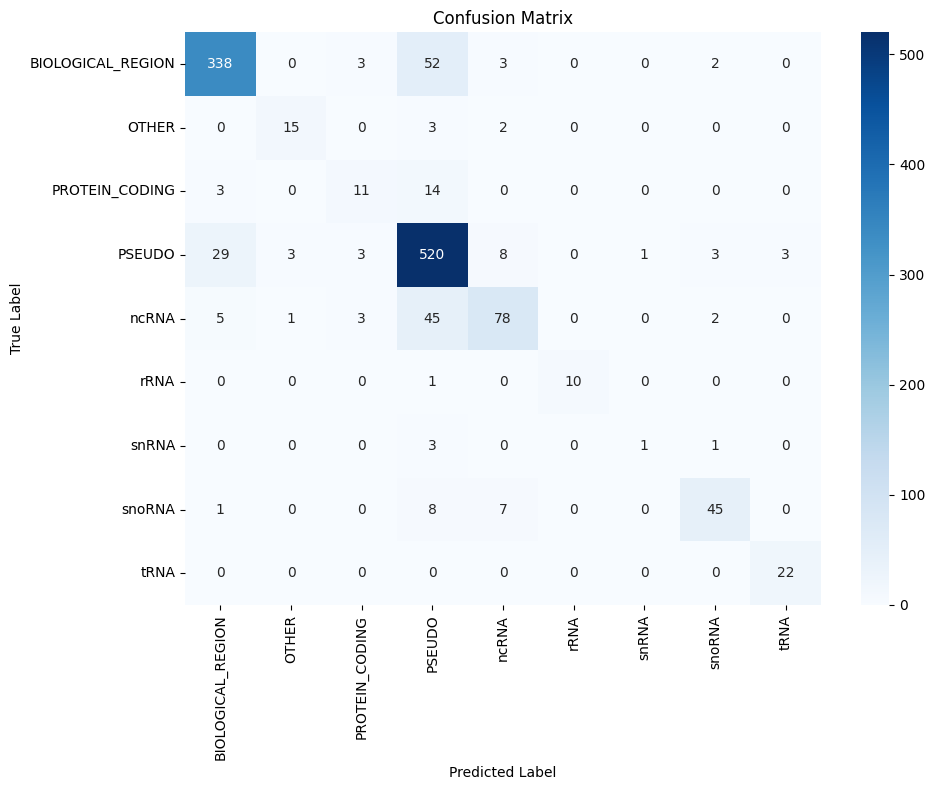


🔍 Predictions on Sample DNA Strings using the CustomDNAClassifier:

🔮 Predicted Mutation Type: ncRNA
📊 Confidence: 57.61%

📈 Top Predictions:
• ncRNA (57.61%)
• PSEUDO (19.90%)
• OTHER (13.50%)

🔮 Predicted Mutation Type: ncRNA
📊 Confidence: 95.06%

📈 Top Predictions:
• ncRNA (95.06%)
• BIOLOGICAL_REGION (4.70%)
• OTHER (0.12%)

🔮 Predicted Mutation Type: PSEUDO
📊 Confidence: 73.65%

📈 Top Predictions:
• PSEUDO (73.65%)
• OTHER (16.01%)
• ncRNA (4.66%)

🔮 Predicted Mutation Type: OTHER
📊 Confidence: 80.32%

📈 Top Predictions:
• OTHER (80.32%)
• PSEUDO (8.65%)
• BIOLOGICAL_REGION (6.98%)


('OTHER', 0.8032047152519226)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Import classification_report and confusion_matrix
from torch.utils.data import Dataset, DataLoader, TensorDataset # Import TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # Import matplotlib for confusion matrix visualization
import seaborn as sns # Import seaborn for better confusion matrix visualization (optional)


# 🔧 Constants (Adjust as needed for this specific model and data processing)
INPUT_FEATURES = 5
SEQ_LEN = 1000 # Fixed sequence length for padding/truncation


# ✅ Utility functions for one-hot encoding
def one_hot_encode_sequence(seq, max_len=SEQ_LEN):
    if not isinstance(seq, str):
        seq = ""
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
    num_features = len(mapping)
    encoded = np.zeros((max_len, num_features), dtype=np.float32)
    for i, nucleotide in enumerate(seq.upper()):
        if i >= max_len: break
        if nucleotide in mapping:
            encoded[i, mapping[nucleotide]] = 1
        else:
            encoded[i, mapping['N']] = 1
    return encoded


# 🎒 Custom Dataset for one-hot encoded data (using TensorDataset directly is often simpler with padded tensors)
# class DNADataset(Dataset):
#     def __init__(self, sequences, labels=None):
#         self.sequences = sequences # Expects pre-padded/truncated one-hot numpy arrays
#         self.labels = labels
#     def __len__(self): return len(self.sequences)
#     def __getitem__(self, idx):
#         x = torch.tensor(self.sequences[idx], dtype=torch.float32).permute(1, 0) # (SeqLen, Features) -> (Features, SeqLen)
#         if self.labels is not None:
#             y = torch.tensor(self.labels[idx], dtype=torch.long)
#             return x, y
#         return x


# 🧠 Custom CNN-based Classifier (ViO-inspired structure)
class CustomDNAClassifier(nn.Module):
    def __init__(self, input_features, hidden_size, num_classes, sequence_length):
        super(CustomDNAClassifier, self).__init__()
        self.conv1 = nn.Conv1d(input_features, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.3)

        # Calculate the size of the flattened tensor dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, input_features, sequence_length)
            dummy_output = self.pool(self.conv1(dummy_input))
            flattened_size = dummy_output.view(dummy_output.size(0), -1).size(1)

        self.fc1 = nn.Linear(flattened_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


# ✅ Load and preprocess dataset
try:
    # Load data (ensure /content/test.csv exists)
    df = pd.read_csv("/content/test.csv")
    print("✅ Data loaded from /content/test.csv")

    # Clean '<' and '>'
    df['seq_clean'] = df['NucleotideSequence'].astype(str).str.replace('<|>', '', regex=True)

    # Keep only rows whose GeneType appears ≥2 times
    counts = df["GeneType"].value_counts()
    # Filter the DataFrame IN PLACE or reassign df to the filtered result
    df = df[df["GeneType"].isin(counts[counts > 1].index)].reset_index(drop=True)
    print(f"✅ Filtered data to keep GeneTypes with >= 2 occurrences. Remaining rows: {len(df)}")


    # Apply one-hot encoding to the cleaned sequences
    # This will result in a list of numpy arrays, each of shape (SEQ_LEN, INPUT_FEATURES)
    sequences_encoded = np.array([one_hot_encode_sequence(seq, max_len=SEQ_LEN) for seq in df['seq_clean']])


    # ✅ Label Encoding
    # Initialize and fit the LabelEncoder on the 'GeneType' column of the FILTERED DataFrame
    le = LabelEncoder()
    df['mutation_label'] = le.fit_transform(df['GeneType']) # Fit and transform on the filtered data
    num_classes = len(le.classes_) # Get the number of classes from the fitted encoder
    print(f"✅ LabelEncoder fitted and labels encoded. Number of classes: {num_classes}")

    labels = df['mutation_label'].tolist()


    # ✅ Split data into train, validation, and test sets
    # Split sequences_encoded (numpy array) and labels (list)
    X_train, X_val_test, y_train, y_val_test = train_test_split(
        sequences_encoded, labels, test_size=0.3, random_state=42, stratify=labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test
    )

    # Convert numpy arrays to torch tensors and permute for Conv1d
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1) # (N, SeqLen, Features) -> (N, Features, SeqLen)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 2, 1)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)


    # ✅ Create Datasets and DataLoaders using TensorDataset
    batch_size = 64 # Batch size for DataLoader

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size) # Define test_loader


    print("✅ Data loaded and DataLoaders created using one-hot encoding.")

except FileNotFoundError:
    print("Error: '/content/test.csv' not found. Please upload the file.")
    raise # Stop execution if the file is not found
except KeyError as e:
     print(f"Error: Required column not found in DataFrame: {e}")
     raise # Stop execution if columns are missing
except Exception as e:
    print(f"An error occurred during data loading and preparation: {e}")
    raise # Re-raise other exceptions


# Determine input_size and sequence_length for the model
# These should be consistent with the processed data tensors
input_size = X_train_tensor.shape[1] # Number of features (5 for one-hot)
sequence_length = X_train_tensor.shape[2] # Sequence length after padding/truncation (1000)

hidden_size = 128 # Hidden layer size for the fully connected layer

# ✅ Initialize model
# num_classes is defined after LabelEncoder fitting
model = CustomDNAClassifier(input_features=input_size, hidden_size=hidden_size, num_classes=num_classes, sequence_length=sequence_length)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("✅ Model initialized.")

# ✅ Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20 # Number of training epochs
print(f"\n🚀 Starting training for {epochs} epochs...")

best_val_acc = 0.0
best_model_path = 'custom_dna_classifier_best.pth'

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy().tolist())
            val_targets.extend(labels.cpu().numpy().tolist())

    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_targets, val_preds)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"↪ New best model saved at epoch {epoch+1} with accuracy {best_val_acc:.4f}!")

print("✅ Training finished.")


# ✅ Evaluate on Test Set
print("\n📊 Evaluating on Test Data...")
# Load the best model weights before evaluating on the test set
try:
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    test_preds, test_targets = [], []
    with torch.no_grad():
        for inputs, labels in test_loader: # Use the defined test_loader
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy().tolist())
            test_targets.extend(labels.cpu().numpy().tolist())

    test_acc = accuracy_score(test_targets, test_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

    # 📊 Classification Report
    print("\n📈 Classification Report:\n")
    # Ensure le is defined for target_names
    try:
        print(classification_report(test_targets, test_preds, target_names=le.classes_))
    except NameError:
        print("Error: LabelEncoder 'le' not defined. Cannot generate classification report.")
    except ValueError as e:
        print(f"Error generating classification report: {e}")
        print("This might be due to a mismatch between predicted labels and the classes in le.")


    # 📊 Confusion Matrix
    try:
        cm = confusion_matrix(test_targets, test_preds)
        plt.figure(figsize=(10, 8))
        # Use le.classes_ for labels on the confusion matrix axes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    except NameError:
        print("\nError: LabelEncoder 'le' not defined. Cannot generate confusion matrix.")
    except Exception as e:
        print(f"\nError generating confusion matrix: {e}")


except FileNotFoundError:
    print(f"Error: Best model weights not found at {best_model_path}. Please ensure training completed successfully.")
except Exception as e:
    print(f"An error occurred during test evaluation: {e}")


# ✅ Prediction on New DNA Strings with Confidence (Using this CustomDNAClassifier)
print("\n🔍 Predictions on Sample DNA Strings using the CustomDNAClassifier:")

# Ensure le is defined for inverse_transform
try:
    le
except NameError:
    print("Error: LabelEncoder 'le' not defined. Cannot perform predictions.")
    # This error should ideally be caught earlier, but including here for robustness.
    pass # Allow subsequent code to run if le was somehow defined later


def predict_new_sequence_with_confidence_custom_cnn(dna_sequence):
    # Ensure one_hot_encode_sequence, SEQ_LEN, model, and device are available
    try:
        one_hot_encode_sequence, SEQ_LEN, model, device
    except NameError:
        print("Error: Required components for prediction (one_hot_encode_sequence, SEQ_LEN, model, device) are not defined.")
        return None # Exit function if components are missing

    model.eval()
    # Encode and prepare the input sequence using one-hot encoding and padding/truncation
    encoded_seq = one_hot_encode_sequence(dna_sequence, max_len=SEQ_LEN)

    # Convert to tensor, add batch dimension, and permute for Conv1d
    input_tensor = torch.tensor(encoded_seq, dtype=torch.float32).unsqueeze(0).to(device)
    input_tensor = input_tensor.permute(0, 2, 1) # (B, SeqLen, Features) -> (B, Features, SeqLen)


    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1).squeeze() # Get probabilities
        top_k = 3 # Get top 3 predictions
        top_probs, top_indices = torch.topk(probs, top_k)

        # Ensure le is defined for inverse_transform
        try:
            le
        except NameError:
            print("Error: LabelEncoder 'le' not defined. Cannot inverse transform predictions.")
            return None # Exit function if le is not defined


        top_classes = le.inverse_transform(top_indices.cpu().numpy())

        print(f"\n🔮 Predicted Mutation Type: {top_classes[0]}")
        print(f"📊 Confidence: {top_probs[0].item() * 100:.2f}%")
        print("\n📈 Top Predictions:")
        for i in range(len(top_classes)):
            print(f"• {top_classes[i]} ({top_probs[i].item() * 100:.2f}%)")

        return top_classes[0], top_probs[0].item()


# Test with sample DNA strings using the custom CNN prediction function
sample1 = "AGCTGACTGAGTAGCTAGCTAGCTGACTGATCGATCGATCGA"
sample2 = "GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG"
sample3 = "ACTGATCGTAGCTAGCTAGATCGATCGTAGCTAGCTAGCTAGCTAG"
sample4 = "TTCGTACGATCGTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGC"

predict_new_sequence_with_confidence_custom_cnn(sample1)
predict_new_sequence_with_confidence_custom_cnn(sample2)
predict_new_sequence_with_confidence_custom_cnn(sample3)
predict_new_sequence_with_confidence_custom_cnn(sample4)

Model export

In [ ]:
# ✅ Export the trained model
export_path = 'helixviper_final.pth'
torch.save(model.state_dict(), export_path)
print(f"✅ Model exported successfully to {export_path}")


✅ Model exported successfully to helixviper_final.pth


***FULL PREDICTION MODEL***

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset # Import TensorDataset
from google.colab import files
import io # Import io for reading uploaded file

# === Upload User File ===
uploaded = files.upload()
user_file = list(uploaded.keys())[0]
print(f"✅ Uploaded file: {user_file}")

# Read the uploaded file into a DataFrame
try:
    # Use io.BytesIO to read the uploaded file content
    df_user = pd.read_csv(io.BytesIO(uploaded[user_file]))
    # Check for the 'sequence' column
    if 'sequence' not in df_user.columns:
        print(f"Error: Column 'sequence' not found in '{user_file}'. Please ensure the column name is correct.")
        print("Available columns:", df_user.columns.tolist())
        raise KeyError("Missing 'sequence' column")

    sequences = df_user['sequence'].tolist()
    print(f"✅ Loaded {len(sequences)} sequences from '{user_file}'")

except KeyError as e:
    print(f"Error processing uploaded file: {e}")
    raise # Re-raise the error
except Exception as e:
    print(f"An unexpected error occurred while reading the file: {e}")
    raise # Re-raise other exceptions


# === Constants (must match training setup from cell kBZtO0LUfINa) ===
# Based on CustomDNAClassifier training in cell kBZtO0LUfINa
INPUT_FEATURES = 5 # Number of features for one-hot encoding (A, C, G, T, N)
SEQ_LEN = 1000 # Fixed sequence length used for padding/truncation

# === Utility function for One-Hot Encoding (matches cell kBZtO0LUfINa) ===
def one_hot_encode_sequence(seq, max_len=SEQ_LEN):
    if not isinstance(seq, str):
        seq = ""
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
    num_features = len(mapping)
    encoded = np.zeros((max_len, num_features), dtype=np.float32)
    for i, nucleotide in enumerate(seq.upper()):
        if i >= max_len: break
        if nucleotide in mapping:
            encoded[i, mapping[nucleotide]] = 1
        else:
            encoded[i, mapping['N']] = 1
    return encoded # Returns shape (max_len, num_features)


# === CustomDNAClassifier Model Definition (matches cell kBZtO0LUfINa) ===
class CustomDNAClassifier(nn.Module):
    def __init__(self, input_features, hidden_size, num_classes, sequence_length):
        super(CustomDNAClassifier, self).__init__()
        self.conv1 = nn.Conv1d(input_features, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.3)

        # Calculate the size of the flattened tensor dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, input_features, sequence_length)
            dummy_output = self.pool(self.conv1(dummy_input))
            flattened_size = dummy_output.view(dummy_output.size(0), -1).size(1)

        self.fc1 = nn.Linear(flattened_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, input_features, sequence_length)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


# === Prepare Data for Prediction ===
# Encode all user sequences using one-hot encoding and padding/truncation
encoded_sequences = np.array([one_hot_encode_sequence(seq, max_len=SEQ_LEN) for seq in sequences])

# Convert to torch tensor and permute for Conv1d (batch, channels, sequence length)
# Current shape is (num_sequences, SEQ_LEN, INPUT_FEATURES)
# Desired shape is (num_sequences, INPUT_FEATURES, SEQ_LEN)
X_tensor = torch.tensor(encoded_sequences, dtype=torch.float32).permute(0, 2, 1)


# === Load Label Encoder from Training ===
# This LabelEncoder must be the one fitted during the CustomDNAClassifier training (cell kBZtO0LUfINa).
# Ensure 'le' is defined from running cell kBZtO0LUfINa.
try:
    le # Check if le is defined and is a LabelEncoder instance
    if not isinstance(le, LabelEncoder):
         print("Warning: 'le' found but it's not a LabelEncoder instance. Attempting to create a new one.")
         # Fallback: If le exists but is not a LabelEncoder, try to create one and fit it
         # This requires access to the original training data labels, which might not be available.
         # A safer approach is to ensure the training cell (kBZtO0LUfINa) is run first.
         # For robustness, let's assume le from kBZtO0LUfINa is available.
         raise NameError("le is not a LabelEncoder") # Force the error if not correct type

    label_encoder = le # Use the existing LabelEncoder
    print("✅ Using LabelEncoder 'le' from previous steps.")

except NameError:
    print("Error: LabelEncoder 'le' not found or is not a valid instance.")
    print("Please ensure the training cell for CustomDNAClassifier (kBZtO0LUfINa) has been run successfully.")
    raise # Stop execution

# === Initialize Model ===
input_size = INPUT_FEATURES # 5
sequence_length = SEQ_LEN # 1000
hidden_size = 128 # Match hidden_size in CustomDNAClassifier __init__ from kBZtO0LUfINa
num_classes = len(label_encoder.classes_) # Match the number of classes from the fitted LabelEncoder

model = CustomDNAClassifier(input_size, hidden_size, num_classes, sequence_length)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"✅ Model initialized with input_size={input_size}, hidden_size={hidden_size}, num_classes={num_classes}, sequence_length={sequence_length}")


# === Load Weights ===
# Load weights from the file saved after training CustomDNAClassifier
weights_path = 'helixviper_final.pth' # Or 'custom_dna_classifier_best.pth' if that's the intended file
try:
    # Check if the weights file exists
    with open(weights_path, 'rb') as f:
        pass # File exists

    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    print(f"✅ Model weights loaded successfully from '{weights_path}'")

except FileNotFoundError:
    print(f"Error: Model weights file '{weights_path}' not found.")
    print("Please ensure the CustomDNAClassifier was trained and saved correctly (e.g., by running cell kBZtO0LUfINa and the export cell).")
    raise # Stop execution
except RuntimeError as e:
     print(f"Error loading model state_dict: {e}")
     print("This is likely due to a mismatch between the current CustomDNAClassifier model instance")
     print("and the saved weights in '{weights_path}'. Ensure the model definition and initialization")
     print("parameters (input_features, hidden_size, num_classes, sequence_length) match")
     print("the ones used when saving the weights.")
     raise # Re-raise the error


# === Predict ===
# Use a DataLoader for batch processing, even if batch size is 1
prediction_dataset = TensorDataset(X_tensor)
prediction_loader = DataLoader(prediction_dataset, batch_size=64) # Use a reasonable batch size for inference

predictions = []
predicted_probs = []
with torch.no_grad():
    for batch in prediction_loader:
        inputs = batch[0].to(device) # TensorDataset returns a tuple, get the input tensor
        outputs = model(inputs) # logits
        probs = torch.softmax(outputs, dim=1) # Convert logits to probabilities

        # Get the predicted class index and probability for the batch
        max_probs, predicted_indices = torch.max(probs, 1)

        # Inverse transform the indices to get the label strings
        batch_predicted_labels = label_encoder.inverse_transform(predicted_indices.cpu().numpy())

        predictions.extend(batch_predicted_labels)
        predicted_probs.extend(max_probs.cpu().numpy().tolist()) # Store probabilities

# === Output Results ===
df_user['predicted_mutation'] = predictions
df_user['prediction_confidence'] = predicted_probs # Add confidence column

output_filename = 'user_predictions.csv'
df_user.to_csv(output_filename, index=False)
print(f"✅ Predictions done! Results saved as: {output_filename}")

# === Let user download results ===
print(f"Downloading '{output_filename}'...")
files.download(output_filename)
print("✅ Download complete.")

Saving test_sequences.csv to test_sequences (2).csv
✅ Uploaded file: test_sequences (2).csv
✅ Loaded 10 sequences from 'test_sequences (2).csv'
✅ Using LabelEncoder 'le' from previous steps.
✅ Model initialized with input_size=5, hidden_size=128, num_classes=9, sequence_length=1000
✅ Model weights loaded successfully from 'helixviper_final.pth'
✅ Predictions done! Results saved as: user_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download complete.
